|<font size="5">Single Subject Network Analysis</font>|
|-----------------------------------------------------|

In [1]:
sub = '130S4990' # Subject ID
ds = '36p' # Denoising Strategy:
# It could be '9p', 'r36p' or '36pscrubbed'
ct = 'pearson' #Correlation Type
tm = 'gce' # Thresholding Method:
           # It could be 'GCE' or 'user_defined'
tv = 0.05  # Thresholding Value

### Import

In [2]:
from config import *
from src.data import subjects
import src.single_subject_analysis.single_subject_analysis as ssa
import networkx as nx
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import sklearn as sk

In [3]:
print('list of available subjects:')
subjects.to_single_sub_analysis

list of available subjects:


[['130S4990'], []]

### Read Data

#### Read Graphs

In [4]:
if tm=='userdefined':
    tm = '%s-%.3f'%(tm,tv)

In [5]:
corrGdir = glob.glob(rootdir + 
                  "/data/04_correlations/corr-%s/ds-%s/*%s*.gexf"%(ct,ds,sub))
adjGdir  = glob.glob(rootdir+
                       "/data/05_adjacency_matrices/tm-*%s*/corr-%s/ds-%s/*%s*.gexf"
                       %(tm,ct,ds,sub))
corrMdir = glob.glob(rootdir +
                     "/data/04_correlations/corr-%s/ds-%s/*%s*.npy"%(ct,ds,sub))
adjMdir  = glob.glob(rootdir +
                     "/data/05_adjacency_matrices/tm-*%s*/corr-%s/ds-%s/*%s*.npy"
                     %(tm,ct,ds,sub))
corrG = nx.read_gexf(corrGdir[0])
adjG  = nx.read_gexf(adjGdir[0])
corrM = np.load(corrMdir[0])
adjM  = np.load(adjMdir[0])

In [6]:
#dirc = ''
#filesnp = glob.glob(rootdir + "/connectivity_derivs/corr/corr/*"+ sub + "*" + denoising_strategy + ".npy")
#filesnp.extend(glob.glob(rootdir + "/connectivity_derivs/corr/adj/" + thresholding_method + "/*"+ sub + "*" + denoising_strategy + "_adj*.npy"))
#print('Graphs:')
#for i in filesnp:
#    name = i.split(".np")[0].split('sub-')[1]
#    exec('sub' + name + '_np = np.load(i)')
#    print('\tsub' + name + '_np')
#    if "adj" in str(i):
#        exec('adjM = sub' + name + '_np.copy()')
#    else:
#        exec('corrM = sub' + name + '_np.copy()')

The giant component:

In [7]:
adjG_gc=[adjG.subgraph(c).copy() for c in nx.connected_components(adjG)]
adjG_gc = adjG_gc[0]
print('Giant component includes %d out of %d total nodes'%(len(adjG_gc.nodes),len(adjG.nodes)))

Giant component includes 359 out of 360 total nodes


#### Read Measures

In [8]:
norm = ""
if normalize_measures:
    norm="_norm"
dirc = '%s/data/06_network_measures/tm-%s/corr-%s/ds-%s/sub-%s'%(rootdir,tm,ct,ds,sub)

gc_global_dir = glob.glob("%s/*global_measures_giant_component.csv"%(dirc))
gc_local_dir  = glob.glob("%s/*local_measures_giant_component%s.csv"%(dirc,norm))
global_dir    = glob.glob("%s/*global_measures.csv"%(dirc))
local_dir     = glob.glob("%s/*local_measures%s.csv"%(dirc,norm))

In [9]:
# Local measures of the whole graph:
loc_mes_adj     = pd.read_csv(local_dir[0], sep='\t')
# Global measures of the whole graph:
glob_mes_adj    = pd.read_csv(global_dir[0], sep='\t')
# Local Measures of the giant component:
gc_loc_mes_adj  = pd.read_csv(gc_local_dir[0], sep='\t')
# Global Measures of the giant component:
gc_glob_mes_adj = pd.read_csv(gc_global_dir[0], sep='\t')

### Histograms

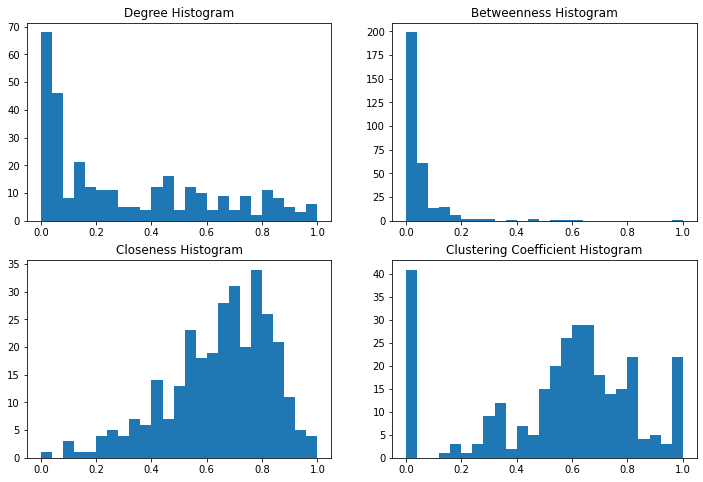

In [10]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
_ = plt.hist(gc_loc_mes_adj['degree'], bins=25) 
plt.title("Degree Histogram")

plt.subplot(2,2,2)
_ = plt.hist(gc_loc_mes_adj['betweenness'], bins=25) 
plt.title("Betweenness Histogram")
                            
plt.subplot(2,2,3)
_ = plt.hist(gc_loc_mes_adj['closeness'], bins=25) 
plt.title("Closeness Histogram")

plt.subplot(2,2,4)
_ = plt.hist(gc_loc_mes_adj['clustering_coef'], bins=25) 
plt.title("Clustering Coefficient Histogram")
plt.show()

### Comparisons

Text(0, 0.5, 'Eigenvector')

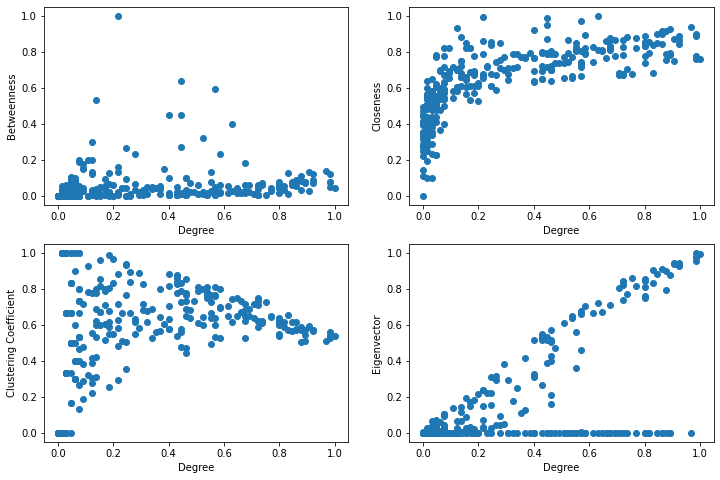

In [11]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.scatter(gc_loc_mes_adj['degree'], gc_loc_mes_adj['betweenness'])
plt.xlabel('Degree')
plt.ylabel('Betweenness')

plt.subplot(2,2,2)
plt.scatter(gc_loc_mes_adj['degree'], gc_loc_mes_adj['closeness'])
plt.xlabel('Degree')
plt.ylabel('Closeness')
                                                     
plt.subplot(2,2,3)
plt.scatter(gc_loc_mes_adj['degree'], gc_loc_mes_adj['clustering_coef'])
plt.xlabel('Degree')
plt.ylabel('Clustering Coefficient')
                                                     
plt.subplot(2,2,4)
plt.scatter(gc_loc_mes_adj['degree'], gc_loc_mes_adj['eigenvector'])
plt.xlabel('Degree')
plt.ylabel('Eigenvector')

### Assotativity

Pearson Correlation Coefficient: 0.21175835413021088


Text(0, 0.5, 'Knn')

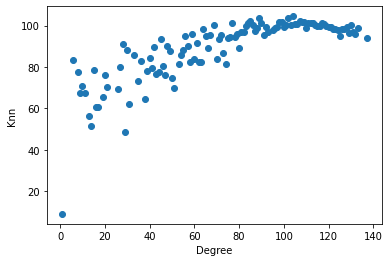

In [12]:
#Assotativity:
print('Pearson Correlation Coefficient:',nx.degree_pearson_correlation_coefficient(adjG_gc))
knn=nx.average_degree_connectivity(adjG_gc)
knn.keys()
plt.scatter(knn.keys(), knn.values())
plt.xlabel('Degree')
plt.ylabel('Knn')

Relationship between knn and clustering coefficient:

In [13]:
#ordered list of degrees
lss=[]
for i in list(adjG_gc.degree(nx.nodes(adjG_gc))):
    lss.append(i[1])
k=list(set(lss))

In [14]:
# knn vs cl
knncl={}
for i in k:
    knncl[nx.k_nearest_neighbors(adjG_gc)[i]] = ssa.clk(adjG_gc,i)

Text(0, 0.5, 'Cl(k)')

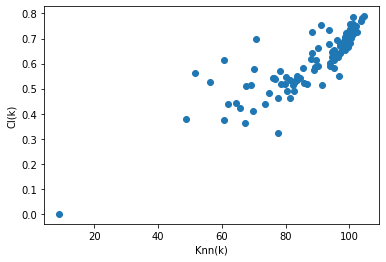

In [15]:
plt.scatter(knncl.keys(), knncl.values())
plt.xlabel('Knn(k)')
plt.ylabel('Cl(k)')

### Rich-club

In [16]:
rch=nx.rich_club_coefficient(adjG_gc, normalized=False)
try:
    rchr=nx.rich_club_coefficient(adjG_gc, normalized=True, Q=110)
except ZeroDivisionError:
    rchr=nx.rich_club_coefficient(adjG_gc, normalized=True, Q=110)

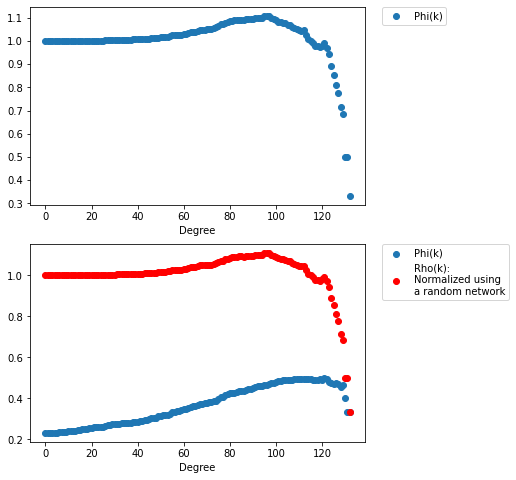

In [17]:
plt.figure(figsize=(6,8))

plt.subplot(2,1,1)
plt.scatter(rchr.keys(), rchr.values())
plt.xlabel('Degree')
plt.legend(['Phi(k)'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.subplot(2,1,2)
plt.scatter(rch.keys(), rch.values())
plt.scatter(rchr.keys(), rchr.values(), c= 'r')
plt.xlabel('Degree')
plt.legend(['Phi(k)', 'Rho(k): \nNormalized using \na random network'],
           bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

### Small world


In [18]:
mll={}
for i in range(1,6):
    mll[i] = ssa.ml(adjG_gc,i)

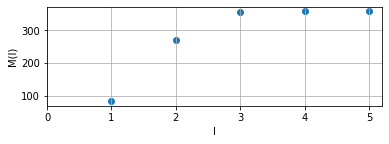

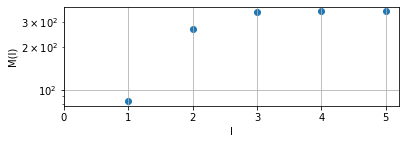

In [19]:
plt.subplot(2,1,1)
plt.scatter(mll.keys(), mll.values())
plt.xlabel('l')
plt.ylabel('M(l)')
plt.xticks(np.arange(0, 6, step=1))
plt.grid(True)
plt.show()

plt.subplot(2,1,2)
plt.scatter(mll.keys(), mll.values())
plt.xlabel('l')
plt.ylabel('M(l)')
plt.xticks(np.arange(0, 6, step=1))
plt.yscale('log')
plt.grid(True)

### Visualize

Overlaying the network onto the brain

In [20]:
from src.viz import viz
len(np.where(ssa.get_adjmtx(corrM,.005)==1)[0])

648

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Top 0.500% Edges, AD Subject: 130S4990, DS: 36p, CT: pearson


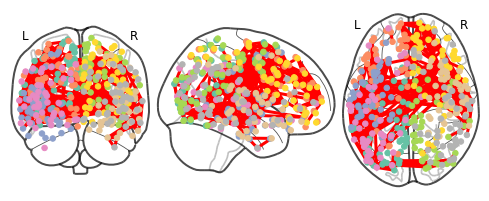

In [5]:
viz.brain_vis(denoising_strategy = ds,
              subjects = [sub], correlation_type = ct,
              density = .005,
              all_ADsubjects = subjects.ADsubjects,
              all_CNsubjects = subjects.CNsubjects,
              method = '2d')

In [ ]:
viz.brain_vis(denoising_strategy = ds,
              subjects = [sub], correlation_type = ct,
              density = .005,
              all_ADsubjects = subjects.ADsubjects,
              all_CNsubjects = subjects.CNsubjects,
              method = '3d')

let's color the nodes using the network assignments that were given to the regions by Yeo et al. (2011).

Giant component includes 359 out of 360 total nodes
black : Undefined
red : Visual
yellow : Somatomotor
green : DorsalAttention
blue : VentralAttention
orange : Limbic
gray : Frontoparietal
magenta : Default


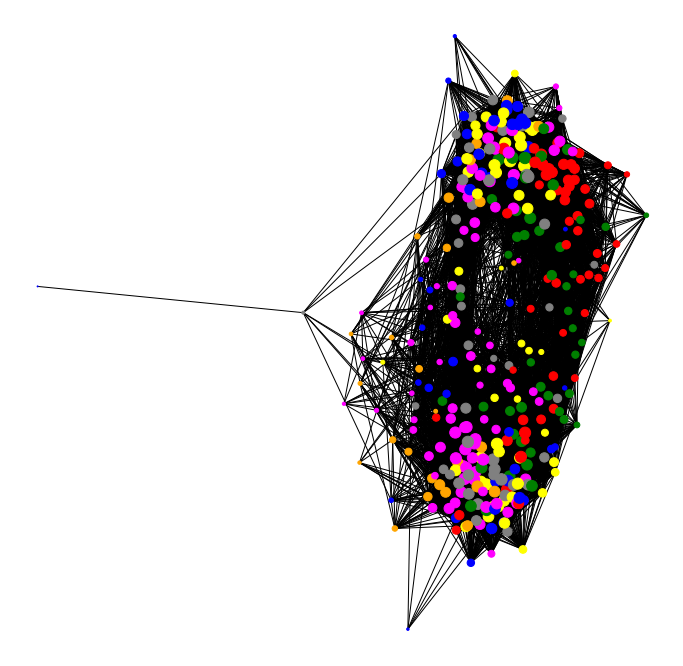

In [11]:
plt.figure(figsize=(12,12))
ssa.gengraph(adjM)

### Community detection

Now let's run our own community detection analysis on the data, to see how the inferred communities relate to the established Yeo et al. networks.

Giant component includes 359 out of 360 total nodes
modularity: 0.5505147592806185
Multilevel modularity optimization identifed 54 communities
Adjusted Rand index compared to Yeo 7 networks: 0.081


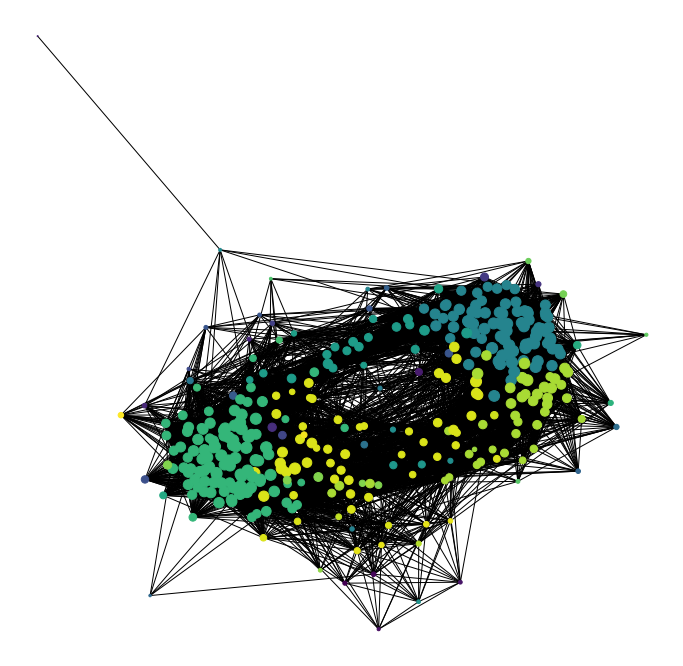

In [10]:
plt.figure(figsize=(12,12))
ssa.comdetc(corrM, adjM, density=.05)

### Save notebook

Run the cells below to save the corrent session

In [12]:
%%javascript
Jupyter.notebook.save_checkpoint()

<IPython.core.display.Javascript object>

In [13]:
%%javascript
Jupyter.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [14]:
#os.system("cp /home/alireza/Thesis/Databases/ADNI/connectivity_derivs/codes/Pipeline/06_single_subject_network_analysis.ipynb /home/alireza/Thesis/Databases/ADNI/connectivity_derivs/codes/Single_Subject_Network_Analysis/sub-%s_%s_%s_network_analysis.ipynb"%(sub,denoising_strategy,thresholding_method))